In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
data_rnn= pd.read_csv("archive/daily/AALI.csv")
data_rnn['timestamp'] = pd.to_datetime(data_rnn['timestamp'])
data_rnn.set_index('timestamp', inplace=True)

In [5]:
data_rnn.isna().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_rnn)

In [20]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # Close price is the target
    return np.array(sequences), np.array(targets)

In [21]:
seq_length = 60
sequences, targets = create_sequences(scaled_data, seq_length)

In [22]:
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

In [23]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 5)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

f:\KULIAH\SEM 4\MachineLearning\FinalProject\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.0280 - val_loss: 3.8742e-04
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.0030 - val_loss: 4.8698e-04
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0027 - val_loss: 3.0359e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0024 - val_loss: 3.7087e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - loss: 0.0024 - val_loss: 5.3269e-04
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - loss: 0.0022 - val_loss: 2.4197e-04
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - loss: 0.0019 - val_loss: 2.5941e-04
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 0.0019 - val_loss: 3.0196e-04
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - loss: 0.0018 - val_loss: 2.2299e-04
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - loss: 0.0016 - val_loss: 3.2200e-04


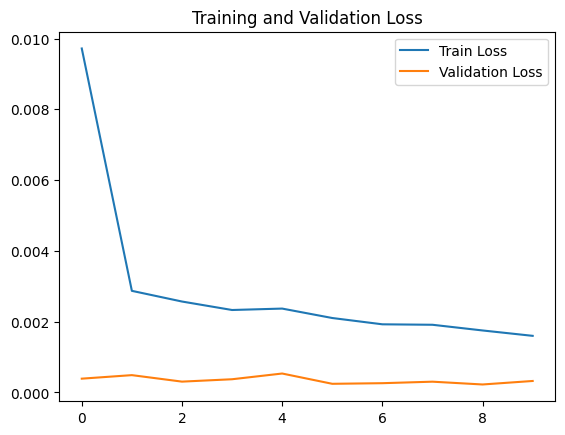

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [27]:
predictions = model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


In [28]:
predictions_scaled = np.zeros((predictions.shape[0], 5))
predictions_scaled[:, 3] = predictions[:, 0]  # Place predictions in the 'close' column
predictions = scaler.inverse_transform(predictions_scaled)[:, 3]

In [29]:
y_test_scaled = np.zeros((y_test.shape[0], 5))
y_test_scaled[:, 3] = y_test  # Place true values in the 'close' column
y_test_actual = scaler.inverse_transform(y_test_scaled)[:, 3]


In [30]:
mse = mean_squared_error(y_test_actual, predictions)
mape = mean_absolute_percentage_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
rmse = sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 Score: {r2}')

MSE: 328575.405989283
RMSE: 573.2149736261981
MAPE: 0.04563903846250132
R2 Score: 0.901641019945106


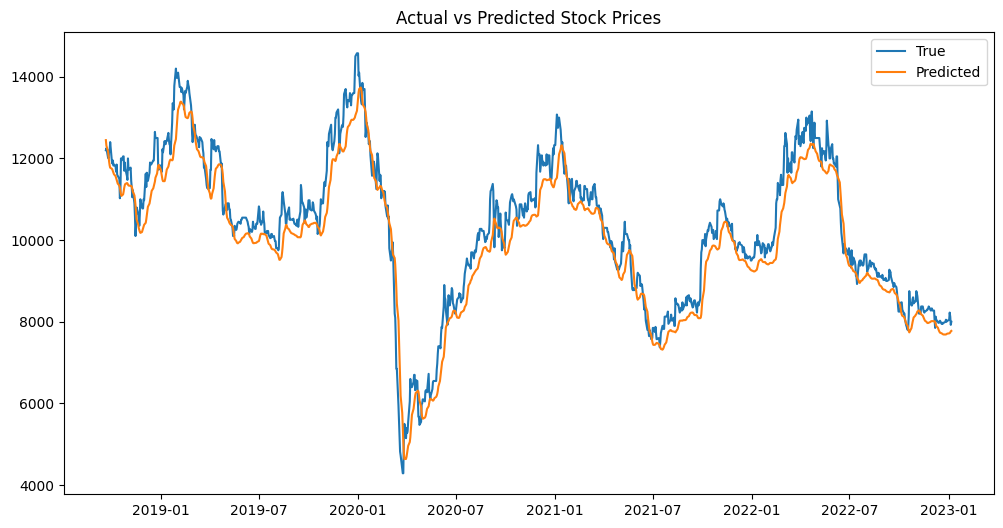

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(data_rnn.index[-len(y_test):], y_test_actual, label='True')
plt.plot(data_rnn.index[-len(y_test):], predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.show()